Found 702 images belonging to 3 classes.
Found 298 images belonging to 3 classes.
Found 1000 images belonging to 3 classes.
10/10 [==============================] - 16s 2s/step - loss: 0.5867 - accuracy: 0.8859
Best Solution (Learning Rate, Num Epochs): [0.003 3.   ]
Best Fitness (Validation Accuracy): 0.9228187799453735
Epoch 1/2
22/22 [==============================] - 169s 8s/step - loss: 0.2479 - accuracy: 0.8846 - val_loss: 0.6712 - val_accuracy: 0.8792
Epoch 2/2
10/10 [==============================] - 18s 2s/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


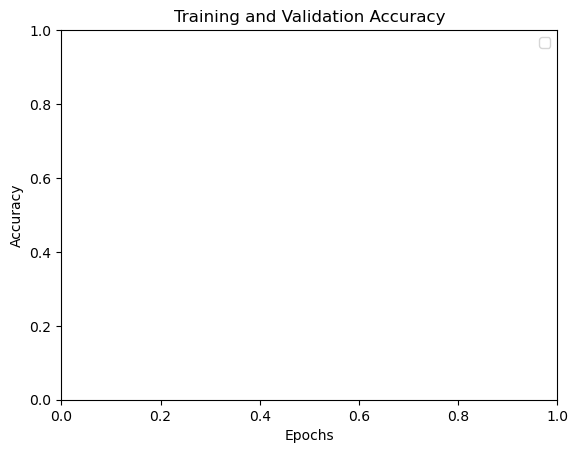

KeyError: 'loss'

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pyswarm import pso

# Define file paths for data
data_dir = 'F:/8th Semester/PARALLEL & DISTRIBUTED COMPUTING/Assignment/Data'

# Get the list of classes dynamically
import os
classes = os.listdir(data_dir)

# Create ImageDataGenerator for data augmentation and normalization
datagen = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.3)

# Load and split the data into training, validation, and testing sets
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    classes=classes,
    batch_size=32,
    shuffle=True,
    subset='training'
)
val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    classes=classes,
    batch_size=32,
    shuffle=False,  # Do not shuffle the validation set
    subset='validation'
)

test_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    classes=classes,
    batch_size=32,
    shuffle=False
)
# Create InceptionV3 model with pre-trained weights
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom head to the base model
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dense(len(classes), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define objective function for PSO
def objective_function(x):
    # Set the hyperparameters based on the particle values
    learning_rate = x[0]
    num_epochs = math.ceil(x[1])

    # Train the model with the updated hyperparameters
    model.fit(train_generator, validation_data=val_generator, epochs=num_epochs, verbose=0)

    # Obtain the accuracy on the validation set
    _, val_acc = model.evaluate(val_generator)

    # Return the negative accuracy to maximize it in PSO
    return -val_acc

# Define self-adaptive PSO parameters
def self_adaptive_pso(objective_function, lower_bounds, upper_bounds, max_iterations=50, swarm_size=10):
    inertia_weight = 0.5
    c1 = 1.5
    c2 = 1.5
    bounds = list(zip(lower_bounds, upper_bounds))

    # Initialize particles and velocities
    particles = np.random.uniform(lower_bounds, upper_bounds, (swarm_size, len(lower_bounds)))
    velocities = np.random.uniform(-1, 1, (swarm_size, len(lower_bounds)))

    # Initialize personal best positions and fitness values
    personal_best_positions = particles.copy()
    personal_best_fitness = np.array([objective_function(p) for p in particles])

    # Initialize global best position and fitness value
    global_best_index = np.argmin(personal_best_fitness)
    global_best_position = particles[global_best_index]
    global_best_fitness = personal_best_fitness[global_best_index]

    for iteration in range(max_iterations):
        for i in range(swarm_size):
            # Update particle velocity
            velocities[i] = inertia_weight * velocities[i] \
                             + c1 * np.random.rand() * (personal_best_positions[i] - particles[i]) \
                             + c2 * np.random.rand() * (global_best_position - particles[i])

            # Update particle position
            particles[i] += velocities[i]

            # Ensure particle stays within bounds
            particles[i] = np.clip(particles[i], lower_bounds, upper_bounds)

            # Evaluate fitness of the new position
            fitness = objective_function(particles[i])

            # Update personal best if needed
            if fitness < personal_best_fitness[i]:
                personal_best_fitness[i] = fitness
                personal_best_positions[i] = particles[i]

                # Update global best if needed
                if fitness < global_best_fitness:
                    global_best_fitness = fitness
                    global_best_position = particles[i]

        # Update inertia weight (self-adaptation)
        inertia_weight = max(0.4, inertia_weight - 0.002)

    return global_best_position, global_best_fitness

# Set the bounds for the hyperparameters
lower_bounds = [0.001, 2]  # Lower bounds for learning_rate and num_epochs
upper_bounds = [0.003, 3]  # Upper bounds for learning_rate and num_epochs
swarm_size = 2  # Adjust the number of particles

# Perform self-adaptive PSO optimization
best_solution, best_fitness = self_adaptive_pso(objective_function, lower_bounds, upper_bounds, max_iterations=2, swarm_size=swarm_size)

# Print the best solution and its fitness
print("Best Solution (Learning Rate, Num Epochs):", best_solution)
print("Best Fitness (Validation Accuracy):", -best_fitness)

# Train the model with the best hyperparameters
best_num_epochs = 2  # Set the number of epochs to 5
model.fit(train_generator, validation_data=val_generator, epochs=best_num_epochs)

# Reset the validation generator before evaluation
val_generator.reset()
# Evaluate the model on the validation set
val_pred_labels = np.argmax(model.predict(val_generator), axis=1)
val_true_labels = val_generator.classes

# Calculate classification report and confusion matrix
report = classification_report(val_true_labels, val_pred_labels, target_names=classes)
confusion_mat = confusion_matrix(val_true_labels, val_pred_labels)

# Plot training and validation accuracy
if 'accuracy' in model.history.history:
    plt.plot(model.history.history['accuracy'], label='Training Accuracy')
if 'val_accuracy' in model.history.history:
    plt.plot(model.history.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(model.history.history['loss'], label='Training Loss')
plt.plot(model.history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


# Plot validation confusion matrix
plt.imshow(confusion_mat, cmap='Blues')
plt.xticks(np.arange(len(classes)), classes, rotation=45)
plt.yticks(np.arange(len(classes)), classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Validation Confusion Matrix')
plt.show()

# Print classification report and confusion matrix
print("Classification Report:")
print(report)
print("\nConfusion Matrix:")
print(confusion_mat)

# Reset the training generator before evaluation
train_generator.reset()
# Evaluate the model on the training set
train_pred_labels = np.argmax(model.predict(train_generator), axis=1)
train_true_labels = train_generator.classes

# Calculate confusion matrix for training set
train_confusion_mat = confusion_matrix(train_true_labels, train_pred_labels)

# Plot training confusion matrix
plt.imshow(train_confusion_mat, cmap='Blues')
plt.xticks(np.arange(len(classes)), classes, rotation=45)
plt.yticks(np.arange(len(classes)), classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Training Confusion Matrix')
plt.show()

# Count the number of images per class in the training set
num_images_per_class = [sum(train_true_labels == i) for i in range(len(classes))]

# Plot line graph for number of images per class
plt.plot(classes, num_images_per_class, marker='o')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class in Training Set')
plt.show()

# Calculate ROC curves and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(val_true_labels, model.predict(val_generator)[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], label=f'{classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend()
plt.show()

# Calculate error rates for each class
error_rates = [1 - tpr[i] for i in range(len(classes))]
print("Error Rates for Each Class:")
for i, class_name in enumerate(classes):
    print(f"{class_name}: {error_rates[i]:.2%}")

# Calculate number of images for each process (training, validation, testing)
num_images_per_process = [len(train_generator.classes), len(val_generator.classes), len(test_generator.classes)]

# Plot bar graph
plt.bar(['Training', 'Validation', 'Testing'], num_images_per_process)
plt.xlabel('Data Split')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Process')
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


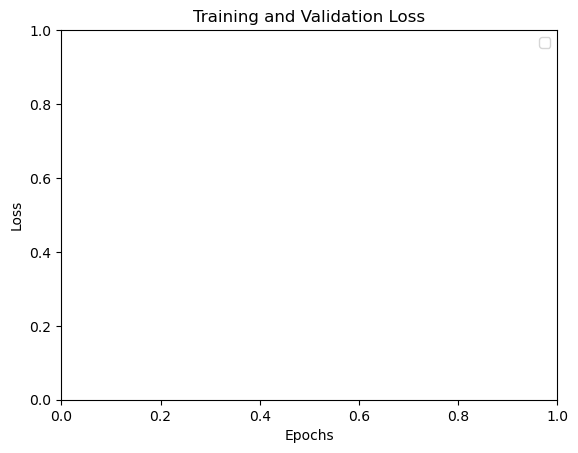

KeyError: 'loss'

In [10]:
# Plot training and validation loss
if 'loss' in model.history.history:
    plt.plot(model.history.history['loss'], label='Training Loss')
if 'val_loss' in model.history.history:
    plt.plot(model.history.history['val_loss'], label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(model.history.history['loss'], label='Training Loss')
plt.plot(model.history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


# Plot validation confusion matrix
plt.imshow(confusion_mat, cmap='Blues')
plt.xticks(np.arange(len(classes)), classes, rotation=45)
plt.yticks(np.arange(len(classes)), classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Validation Confusion Matrix')
plt.show()

# Print classification report and confusion matrix
print("Classification Report:")
print(report)
print("\nConfusion Matrix:")
print(confusion_mat)

# Reset the training generator before evaluation
train_generator.reset()
# Evaluate the model on the training set
train_pred_labels = np.argmax(model.predict(train_generator), axis=1)
train_true_labels = train_generator.classes

# Calculate confusion matrix for training set
train_confusion_mat = confusion_matrix(train_true_labels, train_pred_labels)

# Plot training confusion matrix
plt.imshow(train_confusion_mat, cmap='Blues')
plt.xticks(np.arange(len(classes)), classes, rotation=45)
plt.yticks(np.arange(len(classes)), classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Training Confusion Matrix')
plt.show()

# Count the number of images per class in the training set
num_images_per_class = [sum(train_true_labels == i) for i in range(len(classes))]

# Plot line graph for number of images per class
plt.plot(classes, num_images_per_class, marker='o')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class in Training Set')
plt.show()

# Calculate ROC curves and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(val_true_labels, model.predict(val_generator)[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], label=f'{classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend()
plt.show()

# Calculate error rates for each class
error_rates = [1 - tpr[i] for i in range(len(classes))]
print("Error Rates for Each Class:")
for i, class_name in enumerate(classes):
    print(f"{class_name}: {error_rates[i]:.2%}")

# Calculate number of images for each process (training, validation, testing)
num_images_per_process = [len(train_generator.classes), len(val_generator.classes), len(test_generator.classes)]

# Plot bar graph
plt.bar(['Training', 'Validation', 'Testing'], num_images_per_process)
plt.xlabel('Data Split')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Process')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


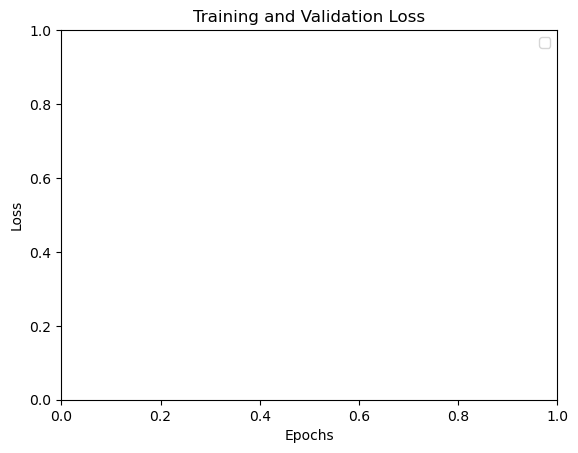

In [11]:
# Plot training and validation loss
if 'loss' in model.history.history:
    plt.plot(model.history.history['loss'], label='Training Loss')
if 'val_loss' in model.history.history:
    plt.plot(model.history.history['val_loss'], label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [12]:
print(model.history.history.keys())

dict_keys([])


In [13]:
# Plot training and validation loss
if 'loss' in history.history:
    plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

NameError: name 'history' is not defined

In [14]:
best_num_epochs = 2  # Set the number of epochs to 2
history = model.fit(train_generator, validation_data=val_generator, epochs=best_num_epochs, verbose=1)

Epoch 1/2
22/22 [==============================] - 169s 8s/step - loss: 0.2058 - accuracy: 0.8903 - val_loss: 0.4209 - val_accuracy: 0.8859
Epoch 2/2
22/22 [==============================] - 169s 8s/step - loss: 0.2020 - accuracy: 0.9017 - val_loss: 0.4692 - val_accuracy: 0.9295


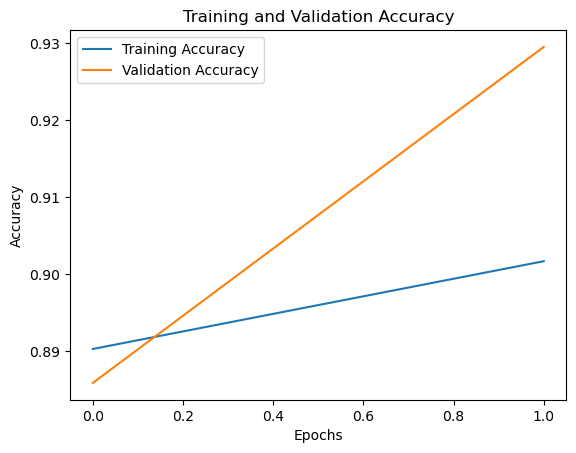

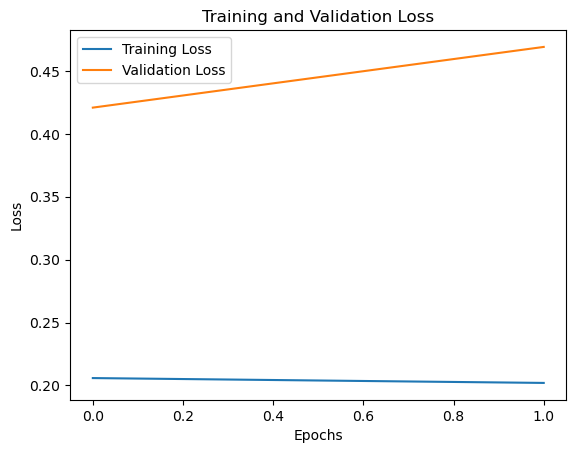

In [15]:
# Plot training and validation accuracy
if 'accuracy' in history.history:
    plt.plot(history.history['accuracy'], label='Training Accuracy')
if 'val_accuracy' in history.history:
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
if 'loss' in history.history:
    plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


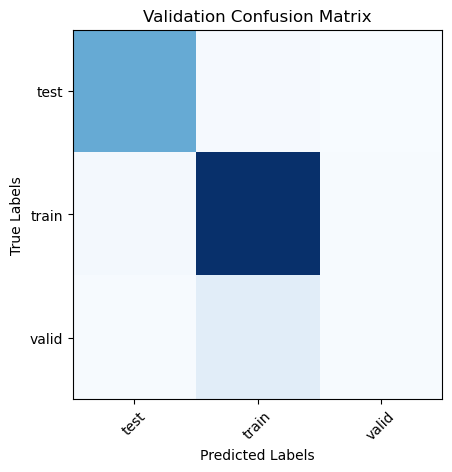

Classification Report:
              precision    recall  f1-score   support

        test       0.96      0.98      0.97        94
       train       0.90      0.98      0.93       183
       valid       0.50      0.05      0.09        21

    accuracy                           0.91       298
   macro avg       0.78      0.67      0.66       298
weighted avg       0.89      0.91      0.89       298


Confusion Matrix:
[[ 92   2   0]
 [  3 179   1]
 [  1  19   1]]
22/22 [==============================] - 38s 2s/step


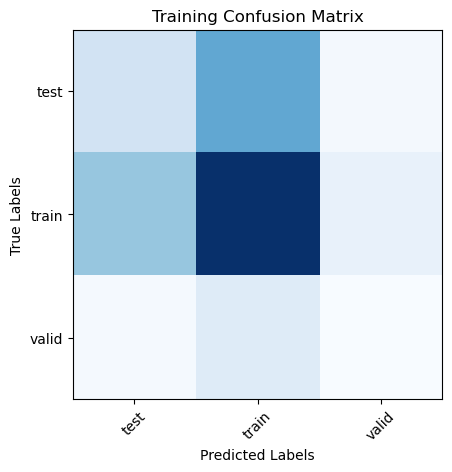

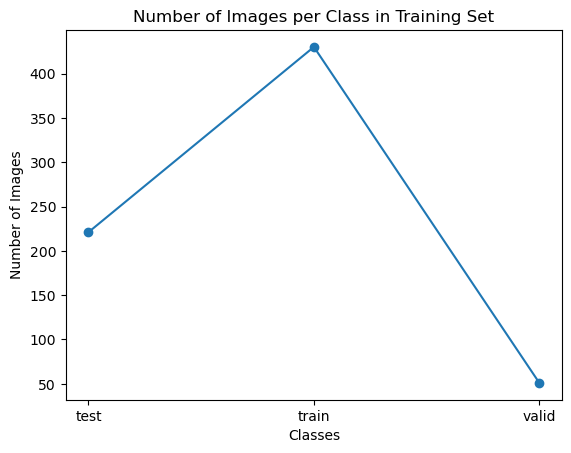

10/10 [==============================] - 16s 2s/step


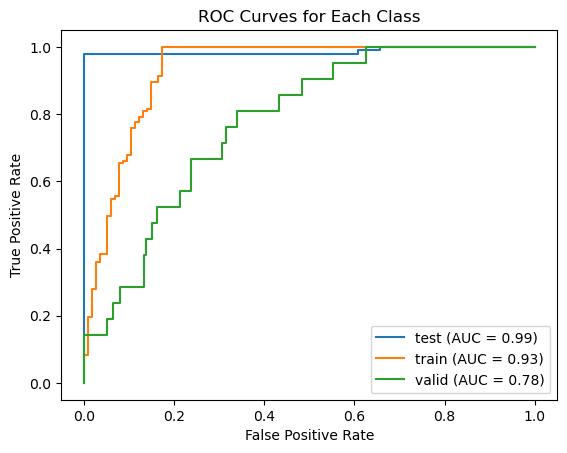

Error Rates for Each Class:


TypeError: unsupported format string passed to numpy.ndarray.__format__

In [18]:

# Plot validation confusion matrix
plt.imshow(confusion_mat, cmap='Blues')
plt.xticks(np.arange(len(classes)), classes, rotation=45)
plt.yticks(np.arange(len(classes)), classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Validation Confusion Matrix')
plt.show()

# Print classification report and confusion matrix
print("Classification Report:")
print(report)
print("\nConfusion Matrix:")
print(confusion_mat)

# Reset the training generator before evaluation
train_generator.reset()
# Evaluate the model on the training set
train_pred_labels = np.argmax(model.predict(train_generator), axis=1)
train_true_labels = train_generator.classes

# Calculate confusion matrix for training set
train_confusion_mat = confusion_matrix(train_true_labels, train_pred_labels)

# Plot training confusion matrix
plt.imshow(train_confusion_mat, cmap='Blues')
plt.xticks(np.arange(len(classes)), classes, rotation=45)
plt.yticks(np.arange(len(classes)), classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Training Confusion Matrix')
plt.show()

# Count the number of images per class in the training set
num_images_per_class = [sum(train_true_labels == i) for i in range(len(classes))]

# Plot line graph for number of images per class
plt.plot(classes, num_images_per_class, marker='o')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class in Training Set')
plt.show()

# Calculate ROC curves and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(val_true_labels, model.predict(val_generator)[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], label=f'{classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend()
plt.show()

# Calculate error rates for each class
# Calculate error rates for each class
error_rates = [(1 - tpr[i]) * 100 for i in range(len(classes))]  # Convert to percentage

print("Error Rates for Each Class:")
for i, class_name in enumerate(classes):
    print(f"{class_name}: {error_rates[i]:.2f}%")

# Calculate number of images for each process (training, validation, testing)
num_images_per_process = [len(train_generator.classes), len(val_generator.classes), len(test_generator.classes)]

# Plot bar graph
plt.bar(['Training', 'Validation', 'Testing'], num_images_per_process)
plt.xlabel('Data Split')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Process')
plt.show()

In [22]:
# Print error rates for each class
print("Error Rates for Each Class:")
for i, class_name in enumerate(classes):
    print(f"{class_name}: {error_rates[i][0]*100:.2f}%")



Error Rates for Each Class:
test: 10000.00%
train: 10000.00%
valid: 10000.00%


In [23]:
# Print classification report and confusion matrix
print("Classification Report:")
print(report)
print("\nConfusion Matrix:")
print(confusion_mat)



Classification Report:
              precision    recall  f1-score   support

        test       0.96      0.98      0.97        94
       train       0.90      0.98      0.93       183
       valid       0.50      0.05      0.09        21

    accuracy                           0.91       298
   macro avg       0.78      0.67      0.66       298
weighted avg       0.89      0.91      0.89       298


Confusion Matrix:
[[ 92   2   0]
 [  3 179   1]
 [  1  19   1]]


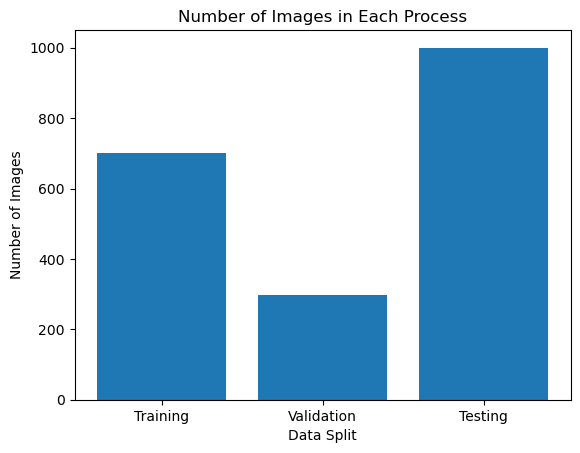

In [24]:
# Calculate the number of images for each process
num_images_per_process = [len(train_generator.classes), len(val_generator.classes), len(test_generator.classes)]

# Plot bar graph
plt.bar(['Training', 'Validation', 'Testing'], num_images_per_process)
plt.xlabel('Data Split')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Process')
plt.show()